# Evaluation of Analyzers using Input Perturbations
This notebook will guide you through an example how to evaluate analyzers via perturbing the input according to the importance that the different input dimensions have.

In particular, several analyzers will be applied to a simple multi-layer perceptron trained on MNIST digits, namely:
* Sensitivity Analysis
* Deconvolution
* Layer-wise relevance propagation

The input images are divided into quadratic regions that are sorted according to their importance wrt to the pixel-wise saliency scores assigned by those analyzers. Then, the information content of the image is gradually destroyed, with the most important regions being affected first, by perturbation. The effect of the perturbation on the classifier's performance is then measured. This procedure is then iteratively repeated for a predermined amount of stepss

We expect that the classifier performance drops quickly if important information is removed and remains largely unaffected when perturbing unimportant regions.

Thus, different analyses can be compared by measuring how quickly the performance drops, i.e. the the quicker the classifier performance drops with to input perturbations wrt to a prediction analysis, the better is the analyzer capable of identifying the input components (mostly) responsible for the model's prediction output.

Similarly, several models can be compared, e.g. with random perturbations on the data, towards their resilience to noisy input data: The faster the model prediction declines with ongoing perturbations, the more susceptible the classifier to (random) noise.



Reference:

*Samek et al. 2017*
"Evaluating the visualization of what a deep neural network has learned." *IEEE transactions on neural networks and learning systems* 28.11 (2017): 2660-2673.

# Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline

import imp
import keras.backend
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import os

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.optimizers import RMSprop

import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis

from innvestigate.tools import Perturbation, PerturbationAnalysis

eutils = imp.load_source("utils", "../utils.py")
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")

Using TensorFlow backend.


# Data
Then, the MNIST data is loaded in its entirety, formatted wrt to the specifications of the keras backend.

In [3]:
channels_first = keras.backend.image_data_format() == "channels_first"
data = mnistutils.fetch_data(channels_first) #returns x_train, y_train, x_test, y_test as numpy.ndarray
num_classes = len(np.unique(data[1]))

60000 train samples
10000 test samples


# Model
We have prepared an (extendable) dictionary of neural network architectures to play around with, some of which are already pre-trained and some which have not seen any `MNIST` data yet.

In [4]:
#         MODELNAME                      INPUT RANGE   EPOCHS   BATCH_SZ   MODEL CREATION KWARGS
models = {'mlp_2dense':                  ([-1, 1],     15,      128,       {'dense_units':1024, 'dropout_rate':0.25}),
          'mlp_3dense':                  ([-1, 1],     20,      128,       {'dense_units':1024, 'dropout_rate':0.25}),
          'cnn_2convb_2dense':           ([-.5, .5],   20,      64,        {}),

          # pre-trained model from [https://doi.org/10.1371/journal.pone.0130140 , http://jmlr.org/papers/v17/15-618.html]
          'pretrained_plos_long_relu':   ([-1, 1],     0,       0,         {}),
          'pretrained_plos_short_relu':  ([-1, 1],     0,       0,         {}),
          'pretrained_plos_long_tanh':   ([-1, 1],     0,       0,         {}),
          'pretrained_plos_short_tanh':  ([-1, 1],     0,       0,         {}),
          }
#Adapt and Play around!

You can select one of the above models by setting the variable `modelname` as below. The corresponding parameters regarding expected input data range, number of training epochs and optional model definition parameters will be fetched from the dictionary.

In [5]:
# Unpack model params by name. The line below currently selects an already pretrained network, which saves some time.
modelname = 'pretrained_plos_long_relu'
activation_type = 'relu'
input_range, epochs, batch_size, kwargs = models[modelname]

Now, preprocess the data wrt to the model's requirements, build the model and optionally train it for `epochs` epochs. 

In [6]:
data_preprocessed = (mnistutils.preprocess(data[0], input_range), data[1],
                     mnistutils.preprocess(data[2], input_range), data[3])

x_test, y_test = data_preprocessed[2:]
# TODO use small subset for developing purposes
x_test, y_test = x_test[:10], y_test[:10] 
y_test = keras.utils.to_categorical(y_test, num_classes)
test_sample = np.copy(x_test[0:1])
generator = iutils.BatchSequence([x_test, y_test], batch_size=256)

model_without_softmax, model_with_softmax = mnistutils.create_model(channels_first, modelname, **kwargs)
mnistutils.train_model(model_with_softmax, data_preprocessed, batch_size=batch_size, epochs=epochs)
model_without_softmax.set_weights(model_with_softmax.get_weights())

Test loss: 0.029667358092008135
Test accuracy: 0.9917


# Perturbation Analysis

### Setup analyzer and perturbation
The perturbation analysis takes several parameters:
* `perturbation_function`: This is the method with which the pixels in the most important regions are perturbated. You can pass your own function or pass a string to select one of the predefined functions, e.g. "zeros", "mean" or "gaussian".
* `region_shape`: The shape of the regions that are considered for perturbation. In this case, we use single pixels. Regions are aggregated ("pooled") using a (customizable) aggregation function that is average pooling by default. The input image is padded such that it can be subdivided into an integer number of regions.
* `steps`: Number of perturbation steps. 
* `ratio`: In each perturbation step, the `ratio` * 100% most important pixels are perturbed.

In [7]:
perturbation_function = "zeros"   # Equivalently, we could provide the string "zeros"
region_shape  = (1, 1) 
steps = 5
ratio = 0.05  # Perturbate 1% of pixels per perturbation step

methods = [
    # NAME                    OPT.PARAMS               POSTPROC FXN                TITLE

    # Show input
    ("input",                 {},                       mnistutils.image,          "Input"),

    # Function
    ("gradient",              {},                       mnistutils.graymap,        "Gradient"),
    ("smoothgrad",            {"noise_scale": 50},      mnistutils.graymap,        "SmoothGrad"),
    ("integrated_gradients",  {},                       mnistutils.graymap,        "Integrated Gradients"),

    # Signal
    ("deconvnet",             {},                       mnistutils.bk_proj,        "Deconvnet"),
    ("guided_backprop",       {},                       mnistutils.bk_proj,        "Guided Backprop",),
    ("pattern.net",           {},                       mnistutils.bk_proj,        "PatternNet"),

    # Interaction
    ("lrp.z_baseline",        {},                       mnistutils.heatmap,         "Gradient*Input"),
    ("lrp.z",                 {},                       mnistutils.heatmap,         "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,         "LRP-Epsilon"),
    ("lrp.composite_a",       {},                       mnistutils.heatmap,         "LRP-CompositeA"),
    #("lrp.composite_b",       {"epsilon": 1},           mnistutils.heatmap,         "LRP-CompositeB"),
    ]

# Select a method of your choice
selected_methods_indices = [1, 2, 8, 9]
selected_methods = [methods[i] for i in selected_methods_indices]
print('Using method(s) "{}".'.format([method[0] for method in selected_methods]))

analyzers = [innvestigate.create_analyzer(method[0],
                                        model_without_softmax,
                                        **method[1]) for method in selected_methods]
for analyzer in analyzers:
    analyzer.fit(data_preprocessed[0],
                     pattern_type=activation_type,
                     batch_size=256, verbose=1)

Using method(s) "['gradient', 'smoothgrad', 'lrp.z', 'lrp.epsilon']".


## 1. Evaluate the model after several perturbation steps

### Setup perturbation
The perturbation analysis consists of two parts:
1. An object of the class `Perturbation` that performs the actual perturbation of input images. Here, we use (1, 1)-regions (i.e. single pixels) and add Gaussian noise to the original values of the most important pixels.
2. An object of the class `PerturbationAnalysis` that computes the analysis, performes several perturbation steps and evaluates the model performance. In each step, the 5% most important pixels are perturbed.

In [8]:
scores_selected_methods = dict()
perturbation_analyses = list()
for method, analyzer in zip(selected_methods, analyzers):
    print("Method: {}".format(method[0]))
    
    # Set up the perturbation analysis
    perturbation = Perturbation(perturbation_function, region_shape=region_shape, in_place=False)
    perturbation_analysis = PerturbationAnalysis(analyzer, model_with_softmax, generator, perturbation,
                                                     steps=steps, ratio=ratio, verbose=True)
    
    scores = perturbation_analysis.compute_perturbation_analysis()
    
    # Store the scores and perturbation analyses for later use
    scores_selected_methods[method[0]] = np.array(scores)
    perturbation_analyses.append(perturbation_analysis)
    print()

Method: gradient
Step 1 of 5: 0% of pixels perturbated. Time elapsed: 0.103 seconds.
Step 2 of 5: 5% of pixels perturbated. Time elapsed: 0.101 seconds.
Step 3 of 5: 10% of pixels perturbated. Time elapsed: 0.103 seconds.
Step 4 of 5: 15% of pixels perturbated. Time elapsed: 0.102 seconds.
Step 5 of 5: 20% of pixels perturbated. Time elapsed: 0.103 seconds.
Time elapsed for 5 steps: 0.513 seconds.

Method: smoothgrad
Step 1 of 5: 0% of pixels perturbated. Time elapsed: 0.216 seconds.
Step 2 of 5: 5% of pixels perturbated. Time elapsed: 0.102 seconds.
Step 3 of 5: 10% of pixels perturbated. Time elapsed: 0.103 seconds.
Step 4 of 5: 15% of pixels perturbated. Time elapsed: 0.103 seconds.
Step 5 of 5: 20% of pixels perturbated. Time elapsed: 0.102 seconds.
Time elapsed for 5 steps: 0.626 seconds.

Method: lrp.z
Step 1 of 5: 0% of pixels perturbated. Time elapsed: 0.204 seconds.
Step 2 of 5: 5% of pixels perturbated. Time elapsed: 0.102 seconds.
Step 3 of 5: 10% of pixels perturbated. Time

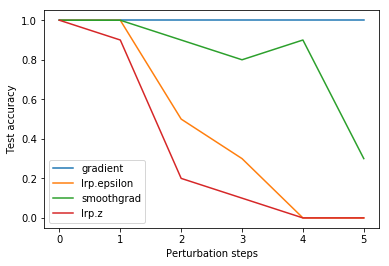

In [9]:
plt.figure()
for method_name in scores_selected_methods.keys():
    scores = scores_selected_methods[method_name]
    plt.plot(scores[:, 1], label=method_name)
plt.xlabel("Perturbation steps")
plt.ylabel("Test accuracy")
plt.xticks(np.array(range(scores.shape[0])))
plt.legend()
plt.show()

## 2. Plot perturbed sample

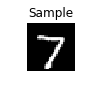

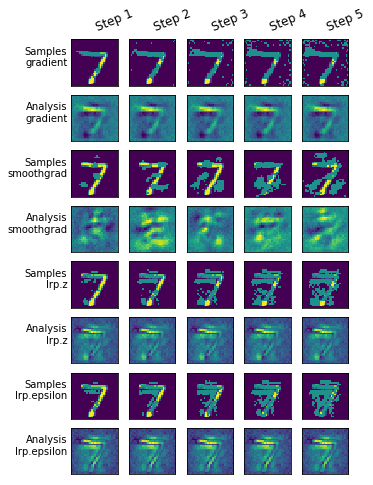

In [10]:
plt.figure()
plt.subplot(2, steps + 1, 1)
plt.imshow(np.squeeze(test_sample), cmap="Greys_r")
plt.axis("off")
plt.title("Sample")

plt.figure()
grid = list()
row_labels = list()
col_labels = ["Step {}".format(i+1) for i in range(steps)]
for perturbation_analysis, method in zip(perturbation_analyses, selected_methods):
    row_labels.extend([["Samples\n{}".format(method[0])], ["Analysis\n{}".format(method[0])]])
    analyses = list()
    samples = list()
    
    # Reset the perturbation_analysis
    perturbation_analysis.perturbation.ratio = 0.0
    for i in range(steps):
        perturbated_test_sample, analysis = perturbation_analysis.compute_on_batch(test_sample, return_analysis=True)
        samples.append(np.squeeze(perturbated_test_sample))
        analyses.append(np.squeeze(analysis))
    grid.extend([samples, analyses])
    
eutils.plot_image_grid(grid, row_labels, list(), col_labels)
plt.show()